In [135]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib
from IPython.display import Image, display, HTML
import base64
import io

Filename: data/mastarall-v3_1_1-v1_7_7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GOODSTARS     1 BinTableHDU     54   24290R x 18C   [6A, 6A, 22A, J, J, J, J, D, D, E, 5E, J, E, E, E, E, 14A, 9A]   
  2  GOODVISITS    1 BinTableHDU     82   59266R x 32C   [6A, 6A, 22A, J, 5A, J, D, D, 5E, J, E, I, I, E, E, I, E, E, I, I, E, J, E, I, E, E, E, D, D, E, 9A, 9A]   
  3  ALLSTARS      1 BinTableHDU     54   28124R x 18C   [6A, 6A, 22A, J, J, J, J, D, D, E, 5E, J, E, E, E, E, 14A, 9A]   
  4  ALLVISITS     1 BinTableHDU     82   80592R x 32C   [6A, 6A, 22A, J, 5A, J, D, D, 5E, J, E, I, I, E, E, I, E, E, I, I, E, J, E, I, E, E, E, D, D, E, 9A, 9A]   
Total stars: 24290


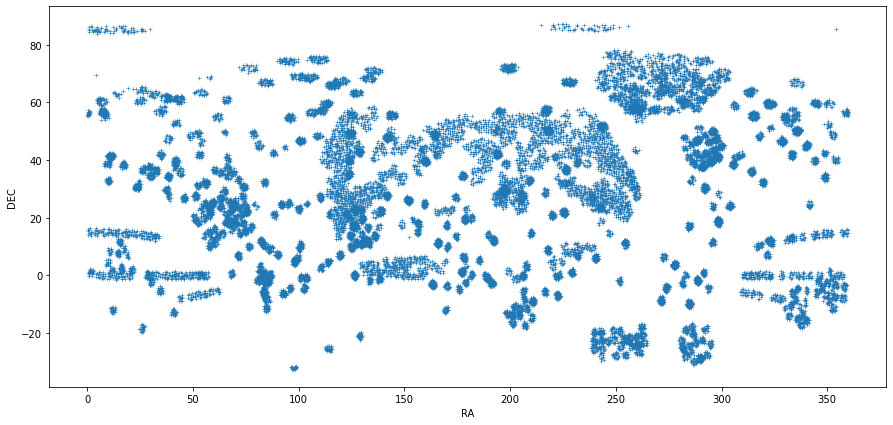

Vaues in PHOTOCAT:
b'ps1      '    8519
b'gaia_dr2 '    5897
b'sdss_dr8 '    5674
b'apass_dr8'    4200
Name: PHOTOCAT, dtype: int64
Data points with valid T value from catalogue:
count    4280.000000
mean     5149.506836
std      1090.677490
min      2970.199951
25%      4396.635010
50%      4907.759521
75%      5694.222412
max      8975.860352
Name: INPUT_TEFF, dtype: float64
Histogram Teff of good-T stars:


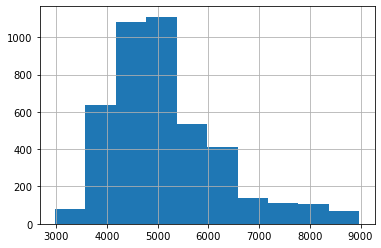

Map of good-T stars:


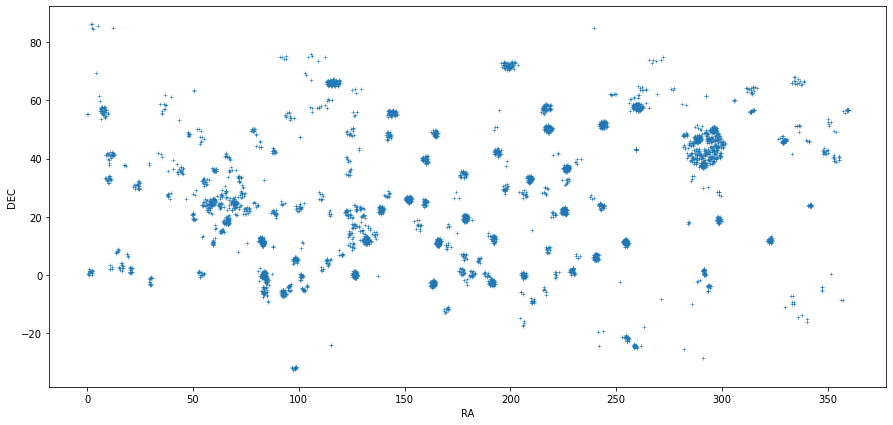

Random good-T star:


,DRPVER,MPROCVER,MANGAID,MINMJD,MAXMJD,NVISITS,NPLATES,RA,DEC,EPOCH,MNGTARG2,INPUT_LOGG,INPUT_TEFF,INPUT_FE_H,INPUT_ALPHA_M,INPUT_SOURCE,PHOTOCAT
19631,b'v3_1_1',b'v1_7_7',b'60-608000110202916352 ',58802,58856,2,1,132.317533,12.334074,2015.500000,65536,4.217208,6238.799805,0.034882,0.148229,b'APOGEE ',b'gaia_dr2 '
23372,b'v3_1_1',b'v1_7_7',b'7-26871985 ',57676,57677,2,1,83.501217,10.556708,2012.000000,1280,4.079000,5844.430176,-0.098000,-999.000000,b'LAMOST ',b'apass_dr8'
3786,b'v3_1_1',b'v1_7_7',b'3-149306936 ',57829,57858,5,1,227.771937,37.405397,2011.800049,1152,-999.000000,-999.000000,-999.000000,-999.000000,b'LAMOST_Mdwarf ',b'ps1 '
17752,b'v3_1_1',b'v1_7_7',b'60-3426270719704110464',58860,58888,4,3,92.230680,24.349241,2015.500000,65536,-999.000000,-999.000000,-999.000000,-999.000000,b'PHOTO_PS1 ',b'gaia_dr2 '
21925,b'v3_1_1',b'v1_7_7',b'7-17746129 ',57510,57510,1,1,293.178419,48.422313,2012.000000,1280,3.742120,5360.111816,-0.033029,0.021036,b'LAMOST_CANNON ',b'apass_dr8'


In [9]:
# Data from https://data.sdss.org/sas/dr17/manga/spectro/mastar/v3_1_1/v1_7_7/
# Data model description https://data.sdss.org/datamodel/files/MANGA_SPECTRO_MASTAR/DRPVER/MPROCVER/mastarall-DRPVER-MPROCVER.html
hdulist = fits.open('data/mastarall-v3_1_1-v1_7_7.fits')
hdulist.info()

dat = Table.read('data/mastarall-v3_1_1-v1_7_7.fits', format='fits', hdu=1)
print('Total stars: %d' % len(dat))

names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
goodstars = dat[names].to_pandas()
goodstars.plot.scatter(x='RA', y='DEC', marker="+", linewidths=0.5, figsize=(15,7))
plt.show()

print("Vaues in PHOTOCAT:")
print(goodstars['PHOTOCAT'].value_counts())

print("Data points with valid T value from catalogue:")
goodstars['INPUT_TEFF'].describe()
tstars = goodstars[goodstars['INPUT_TEFF']>0.0]
print(tstars['INPUT_TEFF'].describe())

print("Histogram Teff of good-T stars:")
tstars['INPUT_TEFF'].hist()
plt.show()

print("Map of good-T stars:")
tstars.plot.scatter(x='RA', y='DEC', marker="+", linewidths=0.5, figsize=(15,7))
plt.show()

print("Random good-T star:")
goodstars.sample(n=5)


Caution is required interpreting the spectra, as resolution differs per star and even per visit https://www.sdss.org/dr17/mastar/mastar-spectra/. SDSS team provides "unified resolution" spectra (with resolutions adjusted to match). Best one to use then should be the "combined" dataset (multiple visits combined to increase quality) and the unified 99.5th set (which is the largest). I think we don't really care about the shape of these LSF curves, as long as they are comparable.

Alternatively, we can use raw data and feed our algorithm with resolution data too. This could give better results because I think normalisation removes detail.

In [3]:
# mastarall-gaiaedr3-extcorr-simbad-ps1-v3_1_1-v1_7_7-v1.fits contains some additional columns taken from gaia catalogue, such as parallax
# Data def is here https://data.sdss.org/datamodel/files/MANGA_SPECTRO_MASTAR/DRPVER/MPROCVER/vac/crossmatch/VER/mastarall-gaiaedr3-extcorr-simbad-ps1-DRPVER-MPROCVER-VER.html
hdulist = fits.open('data/mastarall-gaiaedr3-extcorr-simbad-ps1-v3_1_1-v1_7_7-v1.fits')
hdulist.info()
dat = Table.read('data/mastarall-gaiaedr3-extcorr-simbad-ps1-v3_1_1-v1_7_7-v1.fits', format='fits', hdu=1)
dat[[0,1,2]]

Filename: data/mastarall-gaiaedr3-extcorr-simbad-ps1-v3_1_1-v1_7_7-v1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GOODSTARS     1 BinTableHDU    206   24290R x 94C   [6A, 6A, 22A, J, J, J, J, D, D, E, 5E, J, E, E, E, E, 14A, 9A, 29A, K, E, D, D, D, D, E, E, E, E, E, E, I, J, E, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 5A, 16A, E, E, E, E, E, E, E, 3A, I, I, E, I, E, E, E, E, E, E, E, E, E, K, K, 31A, 15A, 18A, A, 19A, 2A, 18A, 19A, 5I, 5E, 5E, 5E, 5E, 5E, 5E, 5E, K]   
  2  GOODVISITS    1 BinTableHDU    164   59266R x 73C   [6A, 6A, 22A, J, 5A, J, D, D, 5E, J, E, I, I, E, E, I, E, E, I, I, E, J, E, I, E, E, E, D, D, E, 9A, 9A, K, E, D, D, E, E, E, E, E, E, E, 3A, E, I, E, E, E, E, E, E, E, E, E, K, 31A, 15A, 18A, A, 19A, 2A, 18A, 19A, 5I, 5E, 5E, 5E, 5E, 5E, 5E, 5E, K]   
  3  ALLSTARS      1 BinTableHDU    206   28124R x 94C   [6A, 6A, 22A, J, J, J, J, D, D, E, 5E, J, E, E, E, E, 14A, 9A, 29A,

DRPVER,MPROCVER,MANGAID,MINMJD,MAXMJD,NVISITS,NPLATES,RA,DEC,EPOCH,PSFMAG [5],MNGTARG2,INPUT_LOGG,INPUT_TEFF,INPUT_FE_H,INPUT_ALPHA_M,INPUT_SOURCE,PHOTOCAT,DESIGNATION,SOURCE_ID,REF_EPOCH,GAIARA,GAIARA_ERROR,GAIADEC,GAIADEC_ERROR,PARALLAX,PARALLAX_ERROR,PMRA,PMRA_ERROR,PMDEC,PMDEC_ERROR,ASTROMETRIC_PARAMS_SOLVED,ASTROMETRIC_N_GOOD_OBS_AL,ASTROMETRIC_CHI2_AL,VISIBILITY_PERIODS_USED,PHOT_G_MEAN_FLUX,PHOT_G_MEAN_FLUX_OVER_ERROR,PHOT_G_MEAN_MAG,PHOT_BP_MEAN_FLUX,PHOT_BP_MEAN_FLUX_OVER_ERROR,PHOT_BP_MEAN_MAG,PHOT_RP_MEAN_FLUX,PHOT_RP_MEAN_FLUX_OVER_ERROR,PHOT_RP_MEAN_MAG,PHOT_BP_RP_EXCESS_FACTOR,BP_RP,R_MED_GEO,R_LO_GEO,R_HI_GEO,R_MED_PHOTOGEO,R_LO_PHOTOGEO,R_HI_PHOTOGEO,R_FLAG,TMASS_ID,TMASS_DISTANCE,J_M,J_MSIGCOM,H_M,H_MSIGCOM,K_M,K_MSIGCOM,PH_QUAL,GAL_CONTAM,MP_FLG,CONTAMINATION,GAIA_CLEANMATCH,EBV,EBV_SIGMA_UP,EBV_SIGMA_DN,M_G,M_G_ERR_UP,M_G_ERR_DN,BPRPC,BPRPC_ERR_UP,BPRPC_ERR_DN,DUSTCLEAN,GOODSTARS,SIMBAD_MAIN_ID,OTYPE_S,SP_TYPE,SP_QUAL,SP_BIBCODE,MK_DS,MK_SPECTRAL_TYPE,MK_BIBCODE,PS1_NMAG_OK [5],PS1_MEAN [5],PS1_ERR [5],PS1_STDEV [5],PS1_MEDIAN [5],PS1_Q25 [5],PS1_Q75 [5],PS1_MEDIAN_AP [5],PS1_OBJ_ID
bytes6,bytes6,bytes22,int32,int32,int32,int32,float64,float64,float32,float32,int32,float32,float32,float32,float32,bytes14,bytes9,bytes29,int64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,int32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,bytes16,float32,float32,float32,float32,float32,float32,float32,bytes3,int16,int16,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,bytes31,bytes15,bytes18,bytes1,bytes19,bytes2,bytes18,bytes19,int16,float32,float32,float32,float32,float32,float32,float32,int64
v3_1_1,v1_7_7,13-0,56741,56745,3,1,231.01780658696867,41.913900785404856,2003.3239,16.26342 .. 14.904105,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,Gaia EDR3 1390865480240476288,1390865480240476288,2016.0,231.01766555701496,0.025298090651631355,41.913832569495874,0.030044497922062874,0.50258994,0.03409784,-25.366081,0.029792115,-19.648682,0.04169199,31,412,1206.2949,27,18109.506,3655.1206,15.042601,10341.287,740.6116,15.302106,11356.126,829.0937,14.60982,1.1981229,0.69228554,1861.5792,1775.5562,1976.9001,1910.0037,1794.7963,2007.7109,10033,15240428+4154501,0.13108905,14.073,0.026,13.885,0.04,13.821,0.055,AAA,0,0,0.0,1,0.049999997,0.010000002,0.013599997,3.4985201,0.17268096,0.13597098,0.6241392,0.01856478,0.013715437,1,1,,,,,,,,,9 .. 8,7.522757e-07 .. 1.0520259e-06,2.3831912e-09 .. 3.835339e-09,9.72428e-09 .. 1.5595141e-08,7.514121e-07 .. 1.0510656e-06,7.4521523e-07 .. 1.0422388e-06,7.607696e-07 .. 1.0611734e-06,7.5735426e-07 .. 1.0542399e-06,7230230134580793380
v3_1_1,v1_7_7,13-1,56741,56745,3,1,230.9779115513416,41.51587852720575,2003.3239,16.862331 .. 15.488885,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,Gaia EDR3 1390839882235285248,1390839882235285248,2016.0,230.97787214740822,0.024625370278954506,41.51587864924203,0.02397824451327324,0.46039167,0.029003393,-6.1111665,0.029598054,1.9620645,0.03524218,31,391,467.0832,27,10599.103,3162.124,15.624194,6045.938,485.68765,15.884883,6606.726,705.4566,15.197929,1.1937487,0.68695354,2050.3647,1917.6636,2204.3506,2042.8788,1920.9108,2151.9128,10033,15235469+4130571,0.052852284,14.685,0.037,14.483,0.052,14.341,0.084,AAA,0,0,0.0,1,0.04,0.0,0.017199999,3.9618852,0.18124844,0.11291079,0.63248146,0.023503989,0.0027140335,1,1,,,,,,,,,6 .. 5,4.4493285e-07 .. 6.162903e-07,1.7645847e-09 .. 3.1219782e-09,6.6578227e-09 .. 1.0175217e-08,4.4526698e-07 .. 6.1949964e-07,4.4003212e-07 .. 6.1321646e-07,4.4643048e-07 .. 6.203839e-07,4.4597456e-07 .. 6.12279e-07,7212198143885268383
v3_1_1,v1_7_7,13-10,56741,56745,3,1,229.95203771283292,42.26929773840978,2003.406,17.795345 .. 16.309675,1050624,-999.0,-999.0,-999.0,-999.0,,sdss_dr8,Gaia EDR3 1392448295948027520,1392448295948027520,2016.0,229.951973484

In [4]:
# mastar-goodstars-v3_1_1-v1_7_7-params-v1.fits contains params derived by different researchers
# Data def is here https://data.sdss.org/datamodel/files/MANGA_SPECTRO_MASTAR/DRPVER/MPROCVER/vac/parameters/VER/mastar-goodstars-DRPVER-MPROCVER-params-VER.html
hdulist = fits.open('data/mastar-goodstars-v3_1_1-v1_7_7-params-v1.fits')
hdulist.info()
dat = Table.read('data/mastar-goodstars-v3_1_1-v1_7_7-params-v1.fits', format='fits', hdu=1)
dat[[0,1,2]]

Filename: data/mastar-goodstars-v3_1_1-v1_7_7-params-v1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    163   24290R x 73C   [6A, 6A, 22A, J, J, I, I, I, D, D, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, 4I, 11A, I, 4I, 8A, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, E, I, I, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, I]   


DRPVER,MPROCVER,MANGAID,MINMJD,MAXMJD,NVISITS,NPLATES,NGOODVISITS,RA,DEC,EPOCH,MNGTARG2,TEFF_MED,LOGG_MED,FEH_MED,FEH_CAL_MED,ALPHA_MED,ZH_MED,ZH_CAL_MED,TEFF_MED_ERR,LOGG_MED_ERR,FEH_MED_ERR,FEH_CAL_MED_ERR,ALPHA_MED_ERR,ZH_MED_ERR,ZH_CAL_MED_ERR,NGROUPS,INPUT_GROUPS [4],INPUT_GROUPS_NAME,NALPHAGROUPS,INPUT_ALPHA_GROUPS [4],INPUT_ALPHA_GROUPS_NAME,TEFF_JI,LOGG_JI,FEH_JI,ALPHA_JI,VMICRO_JI,TEFF_ERR_JI,LOGG_ERR_JI,FEH_ERR_JI,ALPHA_ERR_JI,VMICRO_ERR_JI,VALID_JI,TEFF_DL,LOGG_DL,FEH_DL,ALPHA_DL,TEFF_ERR_DL,LOGG_ERR_DL,FEH_ERR_DL,ALPHA_ERR_DL,AV_DL,AV_ERR_DL,AV_VALID_DL,VALID_DL,TEFF_LH,LOGG_LH,FEH_LH,ALPHA_LH,TEFF_ERR_LH,LOGG_ERR_LH,FEH_ERR_LH,ALPHA_ERR_LH,VALID_LH,TEFF_YC,LOGG_YC,FEH_YC,ALPHA_YC,TEFF_ERR_YC,LOGG_ERR_YC,FEH_ERR_YC,ALPHA_ERR_YC,VALID_YC
bytes6,bytes6,bytes22,int32,int32,int16,int16,int16,float64,float64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,bytes11,int16,int16,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16
v3_1_1,v1_7_7,13-0,56741,56745,3,1,3,231.01780658696867,41.913900785404856,2003.3239,1050624,6191.071,4.219723,-1.792098,-1.9307878,0.1298964,-1.7046252,-1.843315,137.75697,0.21835943,0.28459492,0.3201387,0.20890057,0.32050836,0.35244876,4,1 .. 1,"ji,dl,lh,yc",3,1 .. 0,"ji,dl,lh",6180.511,4.2151074,-1.7441205,0.1298964,-0.09584684,18.399563,0.04323083,0.02458167,0.013390596,0.027287679,1,6201.6304,4.3336077,-1.8400757,0.17510231,77.41988,0.17680597,0.18059194,0.20890057,0.052960053,0.012031451,1,1,6163.0,3.955576,-1.8851776,0.05613085,289.13992,0.4525479,0.6131209,0.2487366,1,6230.0244,4.224339,-1.6713201,0.025369195,198.09407,0.25991288,0.3885979,0.13884951,1
v3_1_1,v1_7_7,13-1,56741,56745,3,1,3,230.9779115513416,41.51587852720575,2003.3239,1050624,6216.574,4.301462,-1.3324354,-1.376784,0.114812054,-1.2555526,-1.2999012,164.57558,0.29216492,0.33033115,0.3427338,0.24654767,0.37251624,0.38355723,4,1 .. 1,"ji,dl,lh,yc",3,1 .. 0,"ji,dl,lh",6138.902,4.1714764,-1.3305898,0.12656641,-0.09232411,17.564354,0.041336466,0.021629697,0.012421674,0.027498843,1,6270.5386,4.8033395,-1.334281,0.114812054,123.59717,0.32401302,0.20802689,0.25351095,0.026926234,0.0012748792,1,1,6162.61,4.0581994,-1.39935,-0.0050985515,347.36853,0.4111625,0.6620736,0.24654767,1,6318.235,4.4314475,-1.3129147,0.038700227,205.55399,0.26031682,0.45263544,0.14582594,1
v3_1_1,v1_7_7,13-10,56741,56745,3,1,3,229.95203771283292,42.26929773840978,2003.406,1050624,6047.921,5.0,-1.2175925,-1.0344117,0.2564873,-1.0371149,-0.85393405,125.86901,0.39187005,0.18854932,0.15469566,0.1756774,0.23127986,0.20462227,1,0 .. 0,dl,1,0 .. 0,dl,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,6047.921,5.0,-1.2175925,0.2564873,125.86901,0.39187005,0.18854932,0.1756774,0.046790883,0.0016245309,1,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0


In [5]:
# As mentioned before, I think using normalised spectra makes most sense, unless we expect our method to be able to deal with resolution variability.
# Therefore first try using normalised mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits
# Data def is here https://data.sdss.org/datamodel/files/MANGA_SPECTRO_MASTAR/DRPVER/MPROCVER/mastar-combspec-DRPVER-MPROCVER-lsfpercentPP.P.html
hdulist = fits.open('data/mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits')
hdulist.info()
spectra = Table.read('data/mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits', format='fits', hdu=1)
spectra[[0,1,2]]

Filename: data/mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     87   23893R x 35C   [6A, 6A, 22A, D, D, E, 5E, J, 9A, E, I, E, E, I, I, E, 4563D, 4563E, 4563E, 4563E, 4563E, 4563J, I, E, E, E, J, E, I, I, E, E, 2E, I, J]   


DRPVER,MPROCVER,MANGAID,RA,DEC,EPOCH,PSFMAG [5],MNGTARG2,PHOTOCAT,EXPTIME,NVELGOOD,HELIOV,VERR,V_ERRCODE,VELVARFLAG,DV_MAXSIG,WAVE [4563],FLUX [4563],IVAR [4563],DISP [4563],PREDISP [4563],MASK [4563],NEXP_USED,S2N,S2N10,BADPIXFRAC,GOODVISITS_ID,MAXVSHIFT,NVISITS,NPLATES,EXPTIME_MAX,EXPTIME_MIN,SCALEMINMAX [2],SCI,MASTAR_QUAL
bytes6,bytes6,bytes22,float64,float64,float32,float32,int32,bytes9,float32,int16,float32,float32,int16,int16,float32,float64,float32,float32,float32,float32,int32,int16,float32,float32,float32,int32,float32,int16,int16,float32,float32,float32,int16,int32
v3_1_1,v1_7_7,13-0,231.01780658696867,41.913900785404856,2003.3239,16.26342 .. 14.904105,1050624,sdss_dr8,900.11,15,-60.050854,0.8497747,0,0,0.91884124,3621.5959848601933 .. 10353.805444147549,301.57104 .. 0.0,0.0072971634 .. 0.0,1.5208263 .. 2.954979,1.4960281 .. 2.9099424,0 .. 167772160,3,93.81854,110.239395,0.0010957703,27150,0.0,1,1,900.11,900.11,1.0 .. 1.0,0,0
v3_1_1,v1_7_7,13-1,230.9779115513416,41.51587852720575,2003.3239,16.862331 .. 15.488885,1050624,sdss_dr8,900.11,30,-65.59255,1.0004026,0,1,4.591554,3621.5959848601933 .. 10353.805444147549,164.9537 .. 0.0,0.041380003 .. 0.0,1.5208263 .. 2.954979,1.4960281 .. 2.9099424,0 .. 167772160,9,124.32759,144.06245,0.0010957703,27154,3.802063,2,1,900.11,900.105,0.9608172 .. 1.0230947,0,1024
v3_1_1,v1_7_7,13-10,229.95203771283292,42.26929773840978,2003.406,17.795345 .. 16.309675,1050624,sdss_dr8,900.105,45,-196.76616,1.1315472,0,0,0.99534094,3621.5959848601933 .. 10353.805444147549,70.72167 .. 30.104826,0.07304844 .. 0.13305204,1.5208263 .. 2.954979,1.4960281 .. 2.9099424,0 .. 167788544,15,106.181694,124.904465,0.0,27180,5.077667,3,1,900.11,900.1,0.9692881 .. 1.0158587,0,1024


Spectral data consists of: WAVE (frequency value - this is the same for all entries, an x-axis value), FLUX (amount of light reaching the detector, IVAR is the inverse squared, this is the y value), DISP (resolution-related, also PREDISP), MASK (for data goodness?).

When using LFS normalised data, we can ignore DISP (they have all been normalised to the same value).

IVAR is somewhat [described here](https://www.sdss.org/dr14/manga/manga-tutorials/manga-faq/#WhydoyououtputIVAR(inversevariance)insteadoferrors?). Infinite flux is represented by 0.

We can join these spectrums with our main data table via MANGAID.

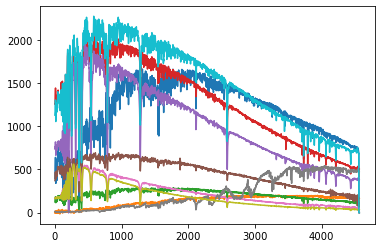

In [166]:
for s in np.random.choice(spectra, size=10):
	plt.plot(s['FLUX'])

This looks good, although:

* some datapoints are negative
* there is some significant dips in the flux values - are these the absorption lines?

Some more info from [MaNGA IDL tutorial](https://www.sdss.org/dr13/manga/manga-tutorials/how-do-i-look-at-my-data/idl/):

* When mask does not equal 0, this indicates a bad pixel. Ivar stands for the inverse variance.
* whenever ivar is 0, this also indicates a bad pixel.

Hopefully these values will help us remove the bad values. So let's put the algorithm togheter:

* zero the values where IVAR is zero or MASK is non-zero
* feed the resulting spectral data (FLUX) into the algorithm
* target the TEFF_INPUT label via join on MANGAID
* initially use a data split on goodstars containing a valid TEFF taken from upstream catalogues (caution is needed, because multiple catalogues are used). There is about 4,000 of these stars.
* we can then further test the algorithm on the extra data provided in the "params" set by comparing how it fared compared to other algorithms (24,290 stars in total)

Alternatively, if 4,000 stars is not enough for training, we can pick one of the values produced by other algorithms (the less-ML) ones, and we can still judge results against other algorithms.


One can look up the actual image via e.g. http://skyserver.sdss.org/dr17/VisualTools/explore/summary?ra=48.873343&dec=-8.442834 (need RA and DEC).

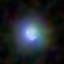

In [108]:

ra = 48.873343
dec = -8.442834

def get_star_image(ra, dec):
   # https://skyserver.sdss.org/dr17/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Explore.Image&ra=48.8733428617884%20&dec=-8.44283369381076&scale=0.2&width=200&height=200&opt=G
   params = {
      'TaskName': 'Skyserver.Explore.Image',
      'ra': ra,
      'dec': dec,
      'scale': 0.2,
      'width': 50,
      'height': 50,
   }
   try:
      with urllib.request.urlopen('http://skyserver.sdss.org/dr17/SkyServerWS/ImgCutout/getjpeg?%s' % urllib.parse.urlencode(params)) as response:
         return response.read()
   except urllib.error.HTTPError as err:
         return b''

display(Image(get_star_image(ra,dec)))

Add it all together to show all the pieces fit.

MANGAID,SDSS image,MaStar Spectrum,Input T,Input source
3-136195064,,,4053K,APOGEE
3-15920589,No image,,6425K,LAMOST
7-11804050,,,4549K,APOGEE
7-14043019,,,4554K,APOGEE
3-137018406,,,5000K,LAMOST_CANNON
3-49859465,,,4936K,APOGEE
3-52994482,,,3046K,APOGEE
7-345628,,,4448K,APOGEE
3-122663716,,,6215K,SEGUE
7-9553060,,,4119K,APOGEE

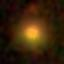
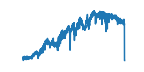
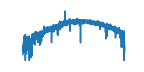
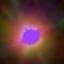
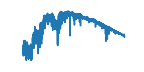
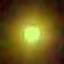
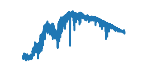
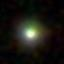
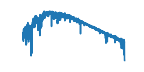
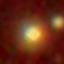
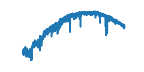
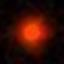
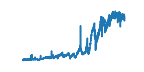
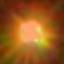
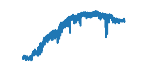
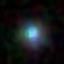
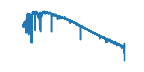
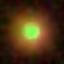
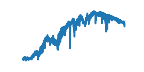
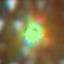
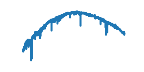
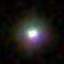
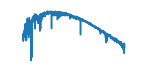
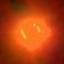
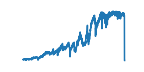
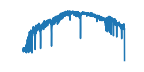
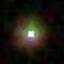
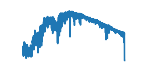
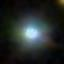
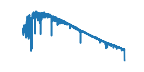
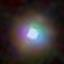
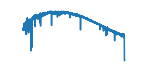
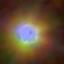
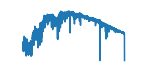
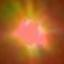
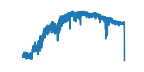
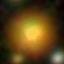
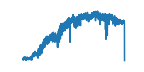
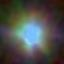
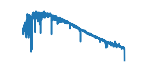
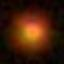
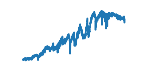
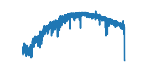
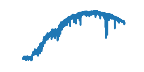
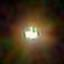
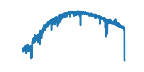

In [170]:
randomstars = tstars.sample(n=25)
o = '<table border=1><tr><th>MANGAID</th><th>SDSS image</th><th>MaStar Spectrum</th><th>Input T</th><th>Input source</th></tr>'
for (id,s) in randomstars.iterrows():
	o += '<tr>'
	id = s['MANGAID']
	o += '<td>%s</td>' % (id.decode('ascii'), )

	starimg = get_star_image(s['RA'], s['DEC'])
	if len(starimg)==0:
		o += '<td>No image</td>'
	else:
		starbase64 = base64.b64encode(starimg).decode('ascii')
		o += '<td><img src="data:image/png;base64,%s"></td>' % starbase64

	sp = spectra[spectra['MANGAID']==id]
	if len(sp)>0:
		plotdata = io.BytesIO()
		plt.figure(figsize=(2, 1))
		plt.axis('off')
		plt.plot(sp[0]['FLUX'])
		plt.savefig(plotdata, format='png')
		plt.close()

		starspec = base64.b64encode(plotdata.getvalue()).decode('ascii')
		o += '<td><img src="data:image/png;base64,%s"></td>' % starspec
	else:
		o += '<td>No spectrum</td>'

	o += "<td>%.0fK</td><td>%s</td>" % (s['INPUT_TEFF'], s['INPUT_SOURCE'].decode('ascii'))
	o += "</tr>\n"
o += '</table>'

display(HTML(o))